In [3]:
import sys
sys.path.append("..")

import config
if str(config.SCRIPTS_DIR) not in sys.path:
    sys.path.append(str(config.SCRIPTS_DIR))

In [5]:
# pip 系のモジュール
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas library for data manipulation and analysis
import optuna
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 自作のモジュール
import myfunctions

In [20]:
df1 = pd.read_csv('Data/Mot_A_rel_2.csv')
df2 = pd.read_csv('Data/Mot_B_rel_1.csv')

# df1が既に定義されていると仮定
X = df1[['d_alpha', 'h_c', 'r', 'w_t', 'l_t', 'w_o', 'dxIB', 'gamma', 'd_alpha_deg', 'hc_mm', 'w_o_mm']]
y = df1[['T', 'TR', 'm_Cu', 'm_mag', 'cos_phi', 'VM', 'Temp']]

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
def optimize_svr(trial, X_train, y_train):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    epsilon = trial.suggest_loguniform('epsilon', 1e-3, 1e1)
    model = SVR(C=C, epsilon=epsilon)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    return score

def optimize_xgb(trial, X_train, y_train):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    }
    model = xgb.XGBRegressor(**param)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    return score


In [14]:
study_svr = optuna.create_study(direction='maximize')
study_svr.optimize(lambda trial: optimize_svr(trial, X_train, y_train['T']), n_trials=100)


[I 2024-12-30 16:00:05,695] A new study created in memory with name: no-name-8f3c1b41-0d7f-4ec9-8a31-f750e5da6381
C:\Users\kazuki\AppData\Local\Temp\ipykernel_1716\1632024685.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
C:\Users\kazuki\AppData\Local\Temp\ipykernel_1716\1632024685.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform('epsilon', 1e-3, 1e1)
[I 2024-12-30 16:00:06,639] Trial 0 finished with value: -1856.9341678116964 and parameters: {'C': 0.00998754210003007, 'epsilon': 0.06854302458373347}. Best is trial 0 with value: -1856.9341678116964.
C:\Users\kazuki\AppData\Local\Temp

In [22]:
# Optunaの最適化
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(lambda trial: optimize_xgb(trial, X_train, y_train['T']), n_trials=100)

[I 2024-12-30 16:50:18,794] A new study created in memory with name: no-name-be3f56bb-2061-4cae-b8b5-dfddb6bf2c20
C:\Users\kazuki\AppData\Local\Temp\ipykernel_1716\2976186199.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
C:\Users\kazuki\AppData\Local\Temp\ipykernel_1716\2976186199.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
[I 2024-12-30 16:50:21,760] Trial 0 finished with value: -234.58380253611122 and parameters: {'max_depth': 7, 'n_estimators': 217, 'eta': 0.01473384758035169, 'gamma': 4.059440338789879e-05, 'grow_policy': 'lossguide'}. Best is tr

In [16]:

# 最適なハイパーパラメータを使用してモデルを学習
best_svr = SVR(C=study_svr.best_params['C'], epsilon=study_svr.best_params['epsilon'])
best_svr.fit(X_train, y_train['T'])

# 最適なハイパーパラメータを使用してモデルを学習
best_xgb = xgb.XGBRegressor(**study_xgb.best_params)
best_xgb.fit(X_train, y_train['T'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.20047509666928562,
             eval_metric=None, feature_types=None, gamma=9.09270651062923e-07,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

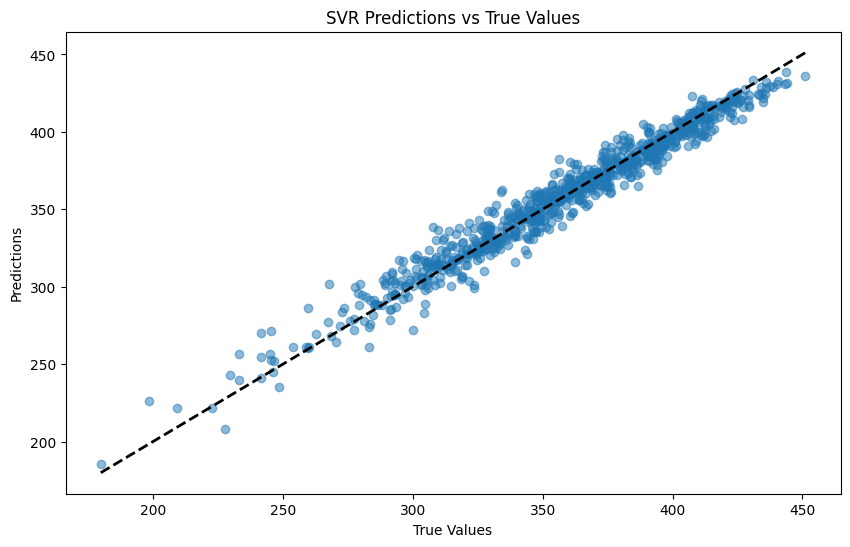

In [17]:
best_model = best_xgb
Y_test = y_test['T']
# テストデータに対する予測
y_pred = best_model.predict(X_test)

# プロット
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('SVR Predictions vs True Values')
plt.show()

In [18]:
# 予測値と真値
y_true = Y_test
y_pred = best_model.predict(X_test)

# R²決定係数
r2 = r2_score(y_true, y_pred)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)

print(f'R²: {r2}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

R²: 0.9600790769932948
RMSE: 8.852327518953503
MAE: 6.765545240214614
